# Neural Networks Homework 
***
**Name**: $<$Yichen Wang$>$ 
***

This assignment is due on Moodle by **11:59pm on Wednesday May 2nd**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 

In [1]:
import pickle, gzip
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as plt_
%matplotlib inline

### [30 points] Problem 1: Building and Training a Feed-Forward Neural Network 
***

In this problem you'll implement a general feed-forward neural network class that utilizes sigmoid activation functions. Your tasks will be to implement `forward propagation`, `prediction`, `back propagation`, `gradient_checking`, and a general `train` routine to learn the weights in your network via Stochastic Gradient Descent.  

The skeleton for the `Network` class is below. Note that this class is almost identical to the one you worked with in the **Lecture 18** in-class notebook, so you should look there to remind yourself of the details.   Scroll down to find more information about your tasks as well as unit tests. 

**Important Note**: In **Problem 2** we'll be using the `Network` class to train a network to do handwritten digit recognition.  Please make sure to utilize vectorized Numpy routines as much as possible, as writing inefficient code here will cause very slow training times in **Problem 2**. 

In [13]:
class Network:
    def __init__(self, sizes):
        """
        Initialize the neural network 
        
        :param sizes: a list of the number of neurons in each layer 
        """
        # save the number of layers in the network 
        self.L = len(sizes) 
        
        # store the list of layer sizes 
        self.sizes = sizes  
        
        # initialize the bias vectors for each hidden and output layer 
        self.b = [np.random.randn(n) for n in self.sizes[1:]]
        
        # initialize the matrices of weights for each hidden and output layer 
        self.W = [np.random.randn(n, m) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the derivatives of biases for backprop 
        self.db = [np.zeros(n) for n in self.sizes[1:]]
        
        # initialize the derivatives of weights for backprop 
        self.dW = [np.zeros((n, m)) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the activities on each hidden and output layer 
        self.z = [np.zeros(n) for n in self.sizes]
        
        # initialize the activations on each hidden and output layer 
        self.a = [np.zeros(n) for n in self.sizes]
        
        # initialize the deltas on each hidden and output layer 
        self.delta = [np.zeros(n) for n in self.sizes]
        
    def g(self, z):
        """
        sigmoid activation function 
        
        :param z: vector of activities to apply activation to 
        """
        z = np.clip(z, -20, 20)
        return 1.0/(1.0 + np.exp(-z))
    
    def g_prime(self, z):
        """
        derivative of sigmoid activation function 
        
        :param z: vector of activities to apply derivative of activation to 
        """
        return self.g(z) * (1.0 - self.g(z))
    
    def C(self, a, y):
        """
        evaluate the cost function for squared-loss C(a,y) = ||a-y||^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return 0.5 * np.linalg.norm(a - y)**2
    
    def gradC(self, a, y):
        """
        evaluate gradient of cost function for squared-loss C(a,y) = ||a-y||^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return (a - y)
    
    def forward_prop(self, x):
        """
        take an feature vector and propagate through network 
        
        :param x: input feature vector 
        """
        
        # TODO: Initialize activation on initial layer to x 
        self.a[0]=x
        
        # TODO: Loop over layers and compute activities and activations 
        for i in range(self.L-1):
            #self.a[i+1]=self.g(np.dot(self.a[i],self.W[i])+self.b[i])
            #for j in range(len(self.W[i])):
            self.z[i+1]=np.matmul(self.W[i],self.a[i])+self.b[i]
            self.a[i+1]=self.g(self.z[i+1])
        return self.a[-1]
        
    def predict(self, X):
        """
        Predicts on the the data in X. Assume at least two output neurons so predictions
        are one-hot encoded vectorized labels. 
        
        :param X: a matrix of data to make predictions on 
        :return y: a matrix of vectorized labels 
        """
        yhat = np.zeros((X.shape[0], self.sizes[-1]), dtype=int)
        
        # TODO: Populate yhat with one-hot-coded predictions 
        for i in range(X.shape[0]):
            output=self.forward_prop(X[i])
            yhat[i][np.argmax(output,axis=0)]=1
            
          
        return yhat 
    
    def accuracy(self, X, y):
        """
        compute accuracy on labeled training set 

        :param X: matrix of features 
        :param y: matrix of vectorized true labels 
        """
        yhat = self.predict(X)
        return np.sum(np.all(np.equal(yhat, y), axis=1)) / X.shape[0]
            
            
    def back_prop(self, x, y):
        """
        Back propagation to get derivatives of C wrt weights and biases for given training example
        
        :param x: training features  
        :param y: vector-encoded label 
        """
        
        # TODO: forward prop training example to fill in activities and activations 
        out_forward_x=self.forward_prop(x)
        
        # TODO: compute deltas on output layer 
        delta_aLC=self.gradC(out_forward_x,y)
        gprimeZ=self.g_prime(self.z[self.L-1])
        self.delta[self.L-1]=np.multiply(delta_aLC,gprimeZ)
        # TODO: loop backward through layers, backprop deltas, compute dWs and dbs
        for ll in range(self.L-2, -1, -1):
            self.dW[ll]=np.outer(self.delta[ll+1],np.array([self.a[ll]]).T)
            self.db[ll]=self.delta[ll+1]
            self.delta[ll]=np.multiply(np.matmul(np.transpose(self.W[ll]),self.delta[ll+1]),self.g_prime(self.z[ll]))
        
    def gradient_checking(self, X_train, y_train, EPS=0.0001):
        """
        Performs gradient checking on all weights in the 
        network for a randomly selected training example 
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        """
        # Randomly select a training example 
        kk = np.random.randint(0,X_train.shape[0])
        xk = X_train[kk]
        yk = y_train[kk]

        # Get the analytic(ish) weights from back_prop 
        self.back_prop(xk, yk)

        # List of relative errors.  Used only for unit testing. 
        rel_errors = []

        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        # Don't forget that after perturbing the weights
        # you'll want to put them back the way they were! 
        
        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        for ell in range(self.L-1):
            for ii in range(self.W[ell].shape[0]):
                # Check weights in level W[ell][ii,jj] 
                for jj in range(self.W[ell].shape[1]):
                    
                    # TODO true_dW  
                    true_dW = self.dW[ell][ii,jj]
                    # TODO num_dW  
                    self.W[ell][ii,jj] += EPS
                    a_C1=self.forward_prop(xk)
                    C1 = self.C(a_C1,yk)
                    #print(self.dW[ell][ii,jj])
                    self.W[ell][ii,jj] -= 2*EPS
                    a_C2=self.forward_prop(xk)
                    C2 = self.C(a_C2,yk)
                    #print(self.dW[ell][ii,jj])
                    num_dW = (C1-C2)/2/EPS
                    self.W[ell][ii,jj] += EPS
                    
                    
                    rel_dW = np.abs(true_dW-num_dW)/np.abs(true_dW)
                    print("W[{:d}][{:d},{:d}]: true: {: 12.10e}  approx: {: 12.10e} rel_err: {: 12.10e}".format(ell, ii, jj, true_dW, num_dW, rel_dW))
                    rel_errors.append(rel_dW)
                    
                # Check bias b[ell][ii]
                
                # TODO true_db  
                true_db=self.db[ell][ii]
                # TODO num_db  
                self.b[ell][ii] += EPS
                a_C1_db=self.forward_prop(xk)
                C1_db = self.C(a_C1_db,yk)
                self.b[ell][ii] -= 2*EPS
                a_C2_db=self.forward_prop(xk)
                C2_db = self.C(a_C2_db,yk)
                num_db = (C1_db-C2_db)/2/EPS
                self.b[ell][ii] += EPS
                
                rel_db = np.abs(true_db-num_db)/np.abs(true_db)
                print("b[{:d}][{:d}]:   true: {: 12.10e}  approx: {: 12.10e} rel_err: {: 12.10e}".format(ell, ii, true_db, num_db, rel_db))
                rel_errors.append(rel_db)

        return rel_errors
            
            
    def train(self, X_train, y_train, X_valid=None, y_valid=None, eta=0.25, lam=0.0, num_epochs=10, isPrint=True):
        """
        Train the network with SGD 
        
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_train: optional matrix of validation features 
        :param y_train: optional matrix of vector-encoded validation labels 
        :param eta: learning rate 
        :param lam: regularization strength 
        :param num_epochs: number of epochs to run 
        :param isPrint: flag indicating to print training progress or not 
        """
        
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        
        self.currentEpoch=[]
        self.validAcc=[]
        # loop over training epochs 
        for ep in range(num_epochs):
            
            # shuffle indices 
            np.random.shuffle(shuffled_inds)
            
            # loop over training examples 
            for ind in shuffled_inds:
                
                # TODO: back prop to get derivatives 
                self.back_prop(X_train[ind],y_train[ind])
                # TODO: update weights and biases 
                for ll in range(self.L-2, -1, -1):
                    self.W[ll] = self.W[ll]-eta*lam*self.W[ll] - eta*self.dW[ll]
                    self.b[ll] = self.b[ll] - eta*self.delta[ll+1]
                
            # occasionally print accuracy
            if isPrint and ((ep+1)%5)==1:
                self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
                self.currentEpoch.append(ep+1)
                self.validAcc.append(self.accuracy(X_valid, y_valid))
                
        # print final accuracy
        if isPrint:
            self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
                
                    
    def epoch_report(self, ep, num_epochs, X_train, y_train, X_valid, y_valid):
        """
        Print the accuracy for the given epoch on training and validation data 
        
        :param ep: the current epoch 
        :param num_epochs: the total number of epochs
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_train: optional matrix of validation features 
        :param y_train: optional matrix of vector-encoded validation labels 
        """
        
        print("epoch {:3d}/{:3d}: ".format(ep+1, num_epochs), end="")
        print("  train acc: {:8.3f}".format(self.accuracy(X_train, y_train)), end="")
        if X_valid is not None: print("  valid acc: {:8.3f}".format(self.accuracy(X_valid, y_valid)))
        else: print("")   
    

**Part A**: Complete the `forward_prop` function in the `Network` class to implement forward propagation.  Your function should take in a single training example `x` and propagate it forward in the network, setting the activations and activities on the hidden and output layers.  When you think you're done, execute the following unit test. 

In [14]:
%run -i nn_tests.py "prob 1A"

testForwardProp (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


**Part B**: Complete the `predict` function in the `Network` class to take in a matrix of features and return a matrix of one-hot-encoded label predictions. Your one-hot-encoded predictions should correspond to the output neuron with the largest activation.   

When you think your `predict` function is working well, execute the following unit test. 

In [15]:
%run -i nn_tests.py "prob 1B"

testPredict (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


**Part C**: OK, now it's time to implement back propagation.  Complete the function ``back_prop`` in the ``Network`` class to use a single training example to compute the derivatives of the loss function with respect to the weights and the biases. As in the **Lecture 18** in-class notebook, you may assume that the loss function for a single training example is given by 

$$
C(y, {\bf a}^L) = \frac{1}{2}\|y - {\bf a}^L\|^2  
$$

When you think you're done, execute the following unit test. 

In [16]:
%run -i nn_tests.py "prob 1C"

testBackProp (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


**Part D**: Due to the fact that we hard-code our various activation functions, cost functions, and their derivatives, it is vital to do some debugging to make sure we haven't made a mistake.  

One common technique is to do **numerical gradient checking**.  In this method we compute numerical approximations of the derivatives of the cost function with respect to the model parameters and compare them to the analytic versions computed by back prop.  

Consider a cost function $C$ which is a function of all of the weights and biases in the network.  We can estimate the derivative of $C$ with respect to a particular parameter using a numerical finite difference technique.  This process looks as follows 

$$
\frac{\partial C}{\partial w_i} \approx \frac{C(w_1,\ldots, w_i+\epsilon, \ldots w_N) - C(w_1,\ldots, w_i-\epsilon, \ldots w_N)}{2\epsilon}
$$

Evaluating the cost function with the perturbed weights can be accomplished by randomly choosing a training example, performing forward propagation, and then evaluating the cost function using the activations in the output layer.  

I've given you starter code down below to do numerical gradient checking.  The code will compute the true and numerical values of the derivative of $C$ with respect to each parameter in the network and then plot the pairs of values as well as their relative errors.  Note that in practice this is extremely expensive, and we typically only check a few random parameters. 

When you believe your code is correct, you can test it by executing the following cell. Note that a good rule of thumb is to train the network for a handful of epochs before doing the gradient checking, to avoid any transient behavior that might occur at the very beginning of the training process. 

In [17]:
%run -i nn_tests.py "prob 1D"

testGradCheck (__main__.TestNN) ... 

W[0][0,0]: true: -1.6129176665e-02  approx: -1.6129176655e-02 rel_err:  6.2758809415e-10
W[0][0,1]: true: -3.2258353331e-02  approx: -3.2258353251e-02 rel_err:  2.4817827221e-09
b[0][0]:   true: -1.6129176665e-02  approx: -1.6129176655e-02 rel_err:  6.2758809415e-10
W[0][1,0]: true:  1.0259238746e-02  approx:  1.0259238739e-02 rel_err:  6.6307893984e-10
W[0][1,1]: true:  2.0518477492e-02  approx:  2.0518477439e-02 rel_err:  2.5974560468e-09
b[0][1]:   true:  1.0259238746e-02  approx:  1.0259238739e-02 rel_err:  6.6307893984e-10
W[0][2,0]: true: -5.1903568015e-04  approx: -5.1903567999e-04 rel_err:  3.0985203531e-10
W[0][2,1]: true: -1.0380713603e-03  approx: -1.0380713582e-03 rel_err:  2.0477984656e-09
b[0][2]:   true: -5.1903568015e-04  approx: -5.1903567999e-04 rel_err:  3.0985203531e-10
W[1][0,0]: true: -7.1372985374e-02  approx: -7.1372985357e-02 rel_err:  2.3383240182e-10
W[1][0,1]: true: -4.3055527018e-02  approx: -4.3055527015e-02 rel_err:  8.6212384741e-11
W[1][0,2]: true: -7.8

ok

----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


**Part E**: OK, now let's actually train a neural net!  Complete the missing code in ``train`` to loop over the training data in random order, call `back_prop` to get the derivatives, and then update the weights and the biases via SGD.  When you think you're done, execute the following code

In [18]:
%run -i nn_tests.py "prob 1E"

testSGD (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


**Part F**: Last but not least, we should implement $\ell$-$2$ regularization.  Modify your `train` function to incorporate regularization of the weights (but **not** the biases) in your SGD update.  As in the Lecture 18 slides, you should assume that the cost function with regularization takes the form 

$$
C_\lambda = C + \frac{\lambda}{2} \displaystyle\sum_{w} w^2
$$

where $\sum_{w}$ sums over each weight in all layers of the network. Think carefully before you go making large changes to your code.  This modification is much simpler than you think. When you think you're done, execute the following unit test.  (Then go back and execute the test in **Part C** to make sure you didn't break anything.) 

In [19]:
%run -i nn_tests.py "prob 1F"

testRegularizedSGD (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### [20 points] Problem 2: A Neural Network Classifier for Handwritten Digit Recognition 
***

In this problem you'll use the Feed-Forward Neural Network framework you wrote in **Problem 1** to take an image of a handwritten digit and predict which digit it corresponds to.  

![Samples of Handwritten Digits](mnist.png "MNIST Digits")

To keep run times down we'll again only consider the subset of the MNIST data set consisting of the digits $3, 7, 8$ and $9$. 

**Part A**: Executing the following cells will load training and validation data and plot an example handwritten digit.  Explore the training and validation sets and answer the following questions: 

- How many pixels are in each image in the data set?  
- How do the true labels correspond to the associated one-hot-encoded label vectors? 
- Give an example of a network architecture with a single hidden layer that is compatible with this data. 


In [20]:
X_train, y_train, X_valid, y_valid = pickle.load(gzip.open("../data/mnist21x21_3789_one_hot.pklz", "rb"))

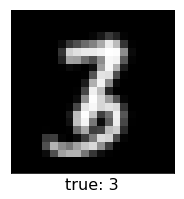

In [21]:
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(21,21), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)
        
training_index = 2
label_dict = dict({0:3, 1:7, 2:8, 3:9})
view_digit(X_train[training_index], label_dict[np.argmax(y_train[training_index])])

In [22]:
print('Number of pixels in each image in the data set',X_train[0].size)

Number of pixels in each image in the data set 441


Label of the 1st image in validation set: [0 1 0 0]


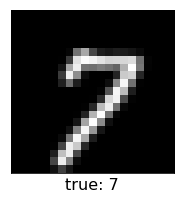

In [23]:
print('Label of the 1st image in validation set:',y_train[0])
view_digit(X_train[0], label_dict[np.argmax(y_train[0])])

From the label vectors we can see that the 4 binary numbers represent the true label. If the first number in the label vector is 1, true label is 3. If the second number is 1, true label is 7. If the third number is 1, true label is 8. If the fourth number is 1, true label is 9.

**Part B**: Train a network with a single hidden layer containing $30$ neurons on the first $500$ training examples in the training set using a learning rate of $\eta = 0.01$ for at least $50$ epochs.  What accuracy does your network achieve on the validation set?  Do you see any clear signs of overfitting?   

In [23]:
nn=Network([441,30,4])
nn.train(X_train[0:500], y_train[0:500], X_valid=X_valid, y_valid=y_valid, eta=0.01, lam=0.0, num_epochs=350, isPrint=True)

epoch   1/350:   train acc:    0.138  valid acc:    0.150
epoch  11/350:   train acc:    0.428  valid acc:    0.405
epoch  21/350:   train acc:    0.620  valid acc:    0.619
epoch  31/350:   train acc:    0.774  valid acc:    0.758
epoch  41/350:   train acc:    0.822  valid acc:    0.813
epoch  51/350:   train acc:    0.862  valid acc:    0.837
epoch  61/350:   train acc:    0.882  valid acc:    0.855
epoch  71/350:   train acc:    0.886  valid acc:    0.868
epoch  81/350:   train acc:    0.894  valid acc:    0.878
epoch  91/350:   train acc:    0.902  valid acc:    0.878
epoch 101/350:   train acc:    0.912  valid acc:    0.881
epoch 111/350:   train acc:    0.916  valid acc:    0.884
epoch 121/350:   train acc:    0.918  valid acc:    0.886
epoch 131/350:   train acc:    0.926  valid acc:    0.887
epoch 141/350:   train acc:    0.932  valid acc:    0.888
epoch 151/350:   train acc:    0.938  valid acc:    0.893
epoch 161/350:   train acc:    0.940  valid acc:    0.895
epoch 171/350:

I ran 350 epochs. The accuracy on validation set increases with the epoch goes up and achieves as high as 0.910 at epoch 261.
At epoch 271 the accuracy on validation set goes down to 0.908, but the accuracy on training set doesn't change. This is a sign of overfitting

**Part C**: Modify the `Network` class so that it stores the accuracies on the training and validation data every $5$ epochs during the training process. Now increase the number of neurons in the hidden layer to $100$.  On a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the learning rates $\eta = 0.01$, $\eta = 0.25$ and $\eta = 1.5$.  Which learning rate seems to perform the best? What is the best accuracy achieved on the validation set?   

epoch   1/100:   train acc:    0.456  valid acc:    0.469
epoch   6/100:   train acc:    0.544  valid acc:    0.539
epoch  11/100:   train acc:    0.697  valid acc:    0.706
epoch  16/100:   train acc:    0.708  valid acc:    0.715
epoch  21/100:   train acc:    0.713  valid acc:    0.721
epoch  26/100:   train acc:    0.718  valid acc:    0.724
epoch  31/100:   train acc:    0.722  valid acc:    0.726
epoch  36/100:   train acc:    0.727  valid acc:    0.729
epoch  41/100:   train acc:    0.744  valid acc:    0.739
epoch  46/100:   train acc:    0.928  valid acc:    0.905
epoch  51/100:   train acc:    0.948  valid acc:    0.923
epoch  56/100:   train acc:    0.954  valid acc:    0.927
epoch  61/100:   train acc:    0.959  valid acc:    0.931
epoch  66/100:   train acc:    0.961  valid acc:    0.930
epoch  71/100:   train acc:    0.963  valid acc:    0.934
epoch  76/100:   train acc:    0.965  valid acc:    0.939
epoch  81/100:   train acc:    0.967  valid acc:    0.939
epoch  86/100:

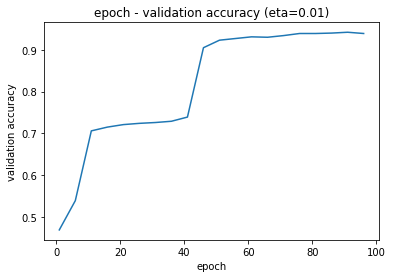

In [34]:
nn1=Network([441,100,4])
nn1.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=0.01, lam=0.0, num_epochs=100, isPrint=True)
epochs1=nn1.currentEpoch
valid_acc1=nn1.validAcc
plt.plot(epochs1,valid_acc1)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('epoch - validation accuracy (eta=0.01)')
plt.show()

epoch   1/100:   train acc:    0.928  valid acc:    0.920
epoch   6/100:   train acc:    0.970  valid acc:    0.945
epoch  11/100:   train acc:    0.984  valid acc:    0.945
epoch  16/100:   train acc:    0.991  valid acc:    0.953
epoch  21/100:   train acc:    0.993  valid acc:    0.956
epoch  26/100:   train acc:    0.993  valid acc:    0.955
epoch  31/100:   train acc:    0.994  valid acc:    0.958
epoch  36/100:   train acc:    0.994  valid acc:    0.958
epoch  41/100:   train acc:    0.994  valid acc:    0.958
epoch  46/100:   train acc:    0.995  valid acc:    0.957
epoch  51/100:   train acc:    0.995  valid acc:    0.956
epoch  56/100:   train acc:    0.995  valid acc:    0.956
epoch  61/100:   train acc:    0.995  valid acc:    0.956
epoch  66/100:   train acc:    0.995  valid acc:    0.958
epoch  71/100:   train acc:    0.995  valid acc:    0.960
epoch  76/100:   train acc:    0.996  valid acc:    0.958
epoch  81/100:   train acc:    0.996  valid acc:    0.957
epoch  86/100:

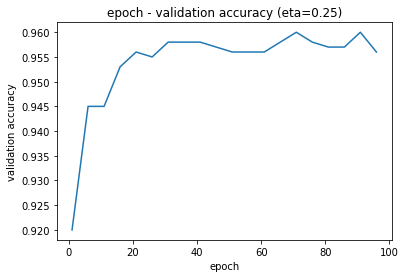

In [35]:
nn2=Network([441,100,4])
nn2.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=0.25, lam=0.0, num_epochs=100, isPrint=True)
epochs2=nn2.currentEpoch
valid_acc2=nn2.validAcc
plt.plot(epochs2,valid_acc2)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('epoch - validation accuracy (eta=0.25)')
plt.show()

epoch   1/100:   train acc:    0.687  valid acc:    0.689
epoch   6/100:   train acc:    0.914  valid acc:    0.900
epoch  11/100:   train acc:    0.953  valid acc:    0.935
epoch  16/100:   train acc:    0.976  valid acc:    0.952
epoch  21/100:   train acc:    0.969  valid acc:    0.944
epoch  26/100:   train acc:    0.983  valid acc:    0.962
epoch  31/100:   train acc:    0.983  valid acc:    0.958
epoch  36/100:   train acc:    0.984  valid acc:    0.960
epoch  41/100:   train acc:    0.989  valid acc:    0.964
epoch  46/100:   train acc:    0.987  valid acc:    0.955
epoch  51/100:   train acc:    0.990  valid acc:    0.956
epoch  56/100:   train acc:    0.989  valid acc:    0.957
epoch  61/100:   train acc:    0.990  valid acc:    0.956
epoch  66/100:   train acc:    0.991  valid acc:    0.955
epoch  71/100:   train acc:    0.994  valid acc:    0.965
epoch  76/100:   train acc:    0.993  valid acc:    0.965
epoch  81/100:   train acc:    0.995  valid acc:    0.957
epoch  86/100:

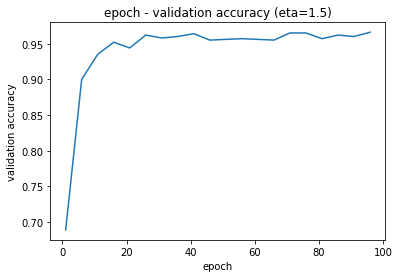

In [36]:
nn3=Network([441,100,4])
nn3.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=0.0, num_epochs=100, isPrint=True)
epochs3=nn3.currentEpoch
valid_acc3=nn3.validAcc
plt.plot(epochs3,valid_acc3)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('epoch - validation accuracy (eta=1.5)')
plt.show()

$\eta=1.5$ seems to perform the best. The highest accuracy reaches 0.966

**Part D**:  Now let's see if we can get better results with regularization. Using the best learning rate you found in **Part C**, on a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the regularization strengths $\lambda = 10^{-6}$, $\lambda = 10^{-4}$ and $\lambda = 10^{-2}$.  Which regularization strength seems to perform the best? What is the best accuracy achieved on the validation set?   

epoch   1/100:   train acc:    0.722  valid acc:    0.713
epoch   6/100:   train acc:    0.955  valid acc:    0.936
epoch  11/100:   train acc:    0.969  valid acc:    0.946
epoch  16/100:   train acc:    0.974  valid acc:    0.957
epoch  21/100:   train acc:    0.979  valid acc:    0.953
epoch  26/100:   train acc:    0.982  valid acc:    0.951
epoch  31/100:   train acc:    0.989  valid acc:    0.960
epoch  36/100:   train acc:    0.992  valid acc:    0.962
epoch  41/100:   train acc:    0.991  valid acc:    0.964
epoch  46/100:   train acc:    0.990  valid acc:    0.954
epoch  51/100:   train acc:    0.992  valid acc:    0.965
epoch  56/100:   train acc:    0.992  valid acc:    0.967
epoch  61/100:   train acc:    0.992  valid acc:    0.964
epoch  66/100:   train acc:    0.994  valid acc:    0.969
epoch  71/100:   train acc:    0.995  valid acc:    0.970
epoch  76/100:   train acc:    0.994  valid acc:    0.967
epoch  81/100:   train acc:    0.995  valid acc:    0.963
epoch  86/100:

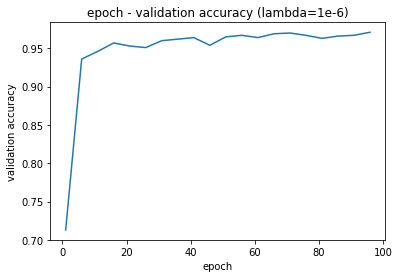

In [37]:
nn4=Network([441,100,4])
nn4.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-6, num_epochs=100, isPrint=True)
epochs4=nn4.currentEpoch
valid_acc4=nn4.validAcc
plt.plot(epochs4,valid_acc4)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('epoch - validation accuracy (lambda=1e-6)')
plt.show()

epoch   1/100:   train acc:    0.919  valid acc:    0.913
epoch   6/100:   train acc:    0.959  valid acc:    0.943
epoch  11/100:   train acc:    0.971  valid acc:    0.957
epoch  16/100:   train acc:    0.970  valid acc:    0.961
epoch  21/100:   train acc:    0.963  valid acc:    0.943
epoch  26/100:   train acc:    0.940  valid acc:    0.905
epoch  31/100:   train acc:    0.953  valid acc:    0.944
epoch  36/100:   train acc:    0.958  valid acc:    0.942
epoch  41/100:   train acc:    0.958  valid acc:    0.942
epoch  46/100:   train acc:    0.935  valid acc:    0.907
epoch  51/100:   train acc:    0.953  valid acc:    0.946
epoch  56/100:   train acc:    0.966  valid acc:    0.948
epoch  61/100:   train acc:    0.961  valid acc:    0.941
epoch  66/100:   train acc:    0.896  valid acc:    0.860
epoch  71/100:   train acc:    0.958  valid acc:    0.942
epoch  76/100:   train acc:    0.957  valid acc:    0.939
epoch  81/100:   train acc:    0.962  valid acc:    0.954
epoch  86/100:

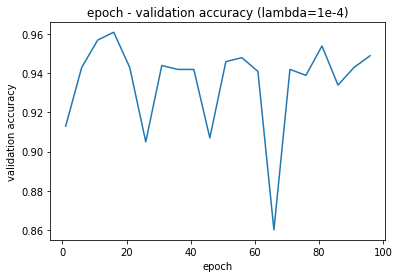

In [40]:
nn5=Network([441,100,4])
nn5.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-4, num_epochs=100, isPrint=True)
epochs5=nn5.currentEpoch
valid_acc5=nn5.validAcc
plt.plot(epochs5,valid_acc5)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('epoch - validation accuracy (lambda=1e-4)')
plt.show()

epoch   1/100:   train acc:    0.499  valid acc:    0.523
epoch   6/100:   train acc:    0.565  valid acc:    0.566
epoch  11/100:   train acc:    0.650  valid acc:    0.649
epoch  16/100:   train acc:    0.465  valid acc:    0.469
epoch  21/100:   train acc:    0.455  valid acc:    0.455
epoch  26/100:   train acc:    0.625  valid acc:    0.631
epoch  31/100:   train acc:    0.448  valid acc:    0.438
epoch  36/100:   train acc:    0.677  valid acc:    0.684
epoch  41/100:   train acc:    0.497  valid acc:    0.512
epoch  46/100:   train acc:    0.426  valid acc:    0.450
epoch  51/100:   train acc:    0.627  valid acc:    0.629
epoch  56/100:   train acc:    0.809  valid acc:    0.802
epoch  61/100:   train acc:    0.646  valid acc:    0.643
epoch  66/100:   train acc:    0.358  valid acc:    0.374
epoch  71/100:   train acc:    0.522  valid acc:    0.538
epoch  76/100:   train acc:    0.596  valid acc:    0.601
epoch  81/100:   train acc:    0.404  valid acc:    0.419
epoch  86/100:

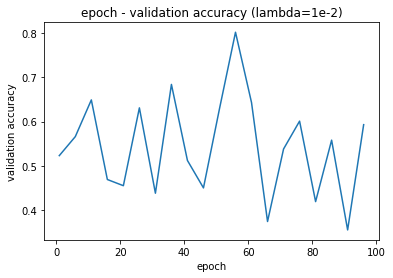

In [41]:
nn6=Network([441,100,4])
nn6.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-2, num_epochs=100, isPrint=True)
epochs6=nn6.currentEpoch
valid_acc6=nn6.validAcc
plt.plot(epochs6,valid_acc6)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('epoch - validation accuracy (lambda=1e-2)')
plt.show()

From the results, $\lambda=10^{-6}$ performs the best. The best accuracy achieved is 0.977

**Part E**:  Now let's see if we can get better results with different network architectures. On a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the architecture from **Part D** as well as two other architectures.  Which architecture seems to perform the best? What is the best accuracy achieved on the validation set?   

In [ ]:
nn7=Network([441,100,4])
nn7.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-6, num_epochs=100, isPrint=True)
epochs7=nn7.currentEpoch
valid_acc7=nn7.validAcc
plt.plot(epochs7,valid_acc7)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('epoch - validation accuracy (lambda=1e-6)')
plt.show()

epoch   1/100:   train acc:    0.654  valid acc:    0.670
epoch   6/100:   train acc:    0.947  valid acc:    0.925
epoch  11/100:   train acc:    0.951  valid acc:    0.934
epoch  16/100:   train acc:    0.952  valid acc:    0.926
epoch  21/100:   train acc:    0.936  valid acc:    0.920
epoch  26/100:   train acc:    0.954  valid acc:    0.938
epoch  31/100:   train acc:    0.956  valid acc:    0.941
epoch  36/100:   train acc:    0.959  valid acc:    0.945
epoch  41/100:   train acc:    0.964  valid acc:    0.949
epoch  46/100:   train acc:    0.732  valid acc:    0.716
epoch  51/100:   train acc:    0.883  valid acc:    0.821
epoch  56/100:   train acc:    0.780  valid acc:    0.774
epoch  61/100:   train acc:    0.946  valid acc:    0.925
epoch  66/100:   train acc:    0.916  valid acc:    0.901
epoch  71/100:   train acc:    0.720  valid acc:    0.715
epoch  76/100:   train acc:    0.693  valid acc:    0.687
epoch  81/100:   train acc:    0.473  valid acc:    0.473
epoch  86/100:

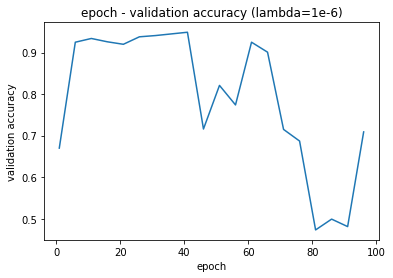

In [42]:
nn8=Network([441,150,80,4])
nn8.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-6, num_epochs=100, isPrint=True)
epochs8=nn8.currentEpoch
valid_acc8=nn8.validAcc
plt.plot(epochs8,valid_acc8)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('epoch - validation accuracy (lambda=1e-6)')
plt.show()

In [ ]:
nn9=Network([441,100,4])
nn9.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-6, num_epochs=100, isPrint=True)
epochs9=nn9.currentEpoch
valid_acc9=nn9.validAcc
plt.plot(epochs9,valid_acc9)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('epoch - validation accuracy (lambda=1e-6)')
plt.show()

### [max 20 points] Extra Credit: Improving Network Performance 
***

See if you can get better performance by exploring advanced techniques.  Things you might try are: 

- Implementing **Mini-Batch** Stochastic Gradient Descent 
- Experimenting with different activation functions (like tanh and **Leaky** ReLU)
- Experimenting with different loss functions (like cross-entropy) 

For more detailed discussion of these techniques it'll be helpful to look at Chapter 3 of [Nielsen](http://neuralnetworksanddeeplearning.com/chap3.html). 

The amount of extra credit you receive will be proportional to the number of above suggested tasks that you complete.  Further, to receive credit for the tasks you must not only implement, but also provide evidence that you've tuned the network to make it work.  Comment on the performance differences between the original `Network` implementation and your new networks with bells and whistles. 

**Important Note**: Don't do any of these things in the original `Network` class, because you'll almost certainly break the unit tests.  Copy the `Network` class from above and rename it `BetterNetwork` (or something) and modify the new class. 


In [ ]:
class BetterNetwork:
    def __init__(self, sizes):
        """
        Initialize the neural network 
        
        :param sizes: a list of the number of neurons in each layer 
        """
        # save the number of layers in the network 
        self.L = len(sizes) 
        
        # store the list of layer sizes 
        self.sizes = sizes  
        
        # initialize the bias vectors for each hidden and output layer 
        self.b = [np.random.randn(n) for n in self.sizes[1:]]
        
        # initialize the matrices of weights for each hidden and output layer 
        self.W = [np.random.randn(n, m) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the derivatives of biases for backprop 
        self.db = [np.zeros(n) for n in self.sizes[1:]]
        
        # initialize the derivatives of weights for backprop 
        self.dW = [np.zeros((n, m)) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the activities on each hidden and output layer 
        self.z = [np.zeros(n) for n in self.sizes]
        
        # initialize the activations on each hidden and output layer 
        self.a = [np.zeros(n) for n in self.sizes]
        
        # initialize the deltas on each hidden and output layer 
        self.delta = [np.zeros(n) for n in self.sizes]
        
    def g(self, z):
        """
        sigmoid activation function 
        
        :param z: vector of activities to apply activation to 
        """
        z = np.clip(z, -20, 20)
        return 1.0/(1.0 + np.exp(-z))
    
    def g_prime(self, z):
        """
        derivative of sigmoid activation function 
        
        :param z: vector of activities to apply derivative of activation to 
        """
        return self.g(z) * (1.0 - self.g(z))
    
    def C(self, a, y):
        """
        evaluate the cost function for squared-loss C(a,y) = ||a-y||^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return 0.5 * np.linalg.norm(a - y)**2
    
    def gradC(self, a, y):
        """
        evaluate gradient of cost function for squared-loss C(a,y) = ||a-y||^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return (a - y)
    
    def forward_prop(self, x):
        """
        take an feature vector and propagate through network 
        
        :param x: input feature vector 
        """
        
        # TODO: Initialize activation on initial layer to x 
        self.a[0]=x
        
        # TODO: Loop over layers and compute activities and activations 
        for i in range(self.L-1):
            #self.a[i+1]=self.g(np.dot(self.a[i],self.W[i])+self.b[i])
            #for j in range(len(self.W[i])):
            self.z[i+1]=np.matmul(self.W[i],self.a[i])+self.b[i]
            self.a[i+1]=self.g(self.z[i+1])
        return self.a[-1]
        
    def predict(self, X):
        """
        Predicts on the the data in X. Assume at least two output neurons so predictions
        are one-hot encoded vectorized labels. 
        
        :param X: a matrix of data to make predictions on 
        :return y: a matrix of vectorized labels 
        """
        yhat = np.zeros((X.shape[0], self.sizes[-1]), dtype=int)
        
        # TODO: Populate yhat with one-hot-coded predictions 
        for i in range(X.shape[0]):
            output=self.forward_prop(X[i])
            yhat[i][np.argmax(output,axis=0)]=1
            
          
        return yhat 
    
    def accuracy(self, X, y):
        """
        compute accuracy on labeled training set 

        :param X: matrix of features 
        :param y: matrix of vectorized true labels 
        """
        yhat = self.predict(X)
        return np.sum(np.all(np.equal(yhat, y), axis=1)) / X.shape[0]
            
            
    def back_prop(self, x, y):
        """
        Back propagation to get derivatives of C wrt weights and biases for given training example
        
        :param x: training features  
        :param y: vector-encoded label 
        """
        
        # TODO: forward prop training example to fill in activities and activations 
        out_forward_x=self.forward_prop(x)
        
        # TODO: compute deltas on output layer 
        delta_aLC=self.gradC(out_forward_x,y)
        gprimeZ=self.g_prime(self.z[self.L-1])
        self.delta[self.L-1]=np.multiply(delta_aLC,gprimeZ)
        # TODO: loop backward through layers, backprop deltas, compute dWs and dbs
        for ll in range(self.L-2, -1, -1):
            self.dW[ll]=np.outer(self.delta[ll+1],np.array([self.a[ll]]).T)
            self.db[ll]=self.delta[ll+1]
            self.delta[ll]=np.multiply(np.matmul(np.transpose(self.W[ll]),self.delta[ll+1]),self.g_prime(self.z[ll]))
        
    def gradient_checking(self, X_train, y_train, EPS=0.0001):
        """
        Performs gradient checking on all weights in the 
        network for a randomly selected training example 
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        """
        # Randomly select a training example 
        kk = np.random.randint(0,X_train.shape[0])
        xk = X_train[kk]
        yk = y_train[kk]

        # Get the analytic(ish) weights from back_prop 
        self.back_prop(xk, yk)

        # List of relative errors.  Used only for unit testing. 
        rel_errors = []

        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        # Don't forget that after perturbing the weights
        # you'll want to put them back the way they were! 
        
        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        for ell in range(self.L-1):
            for ii in range(self.W[ell].shape[0]):
                # Check weights in level W[ell][ii,jj] 
                for jj in range(self.W[ell].shape[1]):
                    
                    # TODO true_dW  
                    true_dW = self.dW[ell][ii,jj]
                    # TODO num_dW  
                    self.W[ell][ii,jj] += EPS
                    a_C1=self.forward_prop(xk)
                    C1 = self.C(a_C1,yk)
                    #print(self.dW[ell][ii,jj])
                    self.W[ell][ii,jj] -= 2*EPS
                    a_C2=self.forward_prop(xk)
                    C2 = self.C(a_C2,yk)
                    #print(self.dW[ell][ii,jj])
                    num_dW = (C1-C2)/2/EPS
                    self.W[ell][ii,jj] += EPS
                    
                    
                    rel_dW = np.abs(true_dW-num_dW)/np.abs(true_dW)
                    print("W[{:d}][{:d},{:d}]: true: {: 12.10e}  approx: {: 12.10e} rel_err: {: 12.10e}".format(ell, ii, jj, true_dW, num_dW, rel_dW))
                    rel_errors.append(rel_dW)
                    
                # Check bias b[ell][ii]
                
                # TODO true_db  
                true_db=self.db[ell][ii]
                # TODO num_db  
                self.b[ell][ii] += EPS
                a_C1_db=self.forward_prop(xk)
                C1_db = self.C(a_C1_db,yk)
                self.b[ell][ii] -= 2*EPS
                a_C2_db=self.forward_prop(xk)
                C2_db = self.C(a_C2_db,yk)
                num_db = (C1_db-C2_db)/2/EPS
                self.b[ell][ii] += EPS
                
                rel_db = np.abs(true_db-num_db)/np.abs(true_db)
                print("b[{:d}][{:d}]:   true: {: 12.10e}  approx: {: 12.10e} rel_err: {: 12.10e}".format(ell, ii, true_db, num_db, rel_db))
                rel_errors.append(rel_db)

        return rel_errors
            
            
    def train(self, X_train, y_train, X_valid=None, y_valid=None, eta=0.25, lam=0.0, num_epochs=10, isPrint=True):
        """
        Train the network with SGD 
        
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_train: optional matrix of validation features 
        :param y_train: optional matrix of vector-encoded validation labels 
        :param eta: learning rate 
        :param lam: regularization strength 
        :param num_epochs: number of epochs to run 
        :param isPrint: flag indicating to print training progress or not 
        """
        
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        
        self.currentEpoch=[]
        self.validAcc=[]
        # loop over training epochs 
        for ep in range(num_epochs):
            
            # shuffle indices 
            np.random.shuffle(shuffled_inds)
            
            # loop over training examples 
            for ind in shuffled_inds:
                
                # TODO: back prop to get derivatives 
                self.back_prop(X_train[ind],y_train[ind])
                # TODO: update weights and biases 
                for ll in range(self.L-2, -1, -1):
                    self.W[ll] = self.W[ll]-eta*lam*self.W[ll] - eta*self.dW[ll]
                    self.b[ll] = self.b[ll] - eta*self.delta[ll+1]
                
            # occasionally print accuracy
            if isPrint and ((ep+1)%5)==1:
                self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
                self.currentEpoch.append(ep+1)
                self.validAcc.append(self.accuracy(X_valid, y_valid))
                
        # print final accuracy
        if isPrint:
            self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
                
                    
    def epoch_report(self, ep, num_epochs, X_train, y_train, X_valid, y_valid):
        """
        Print the accuracy for the given epoch on training and validation data 
        
        :param ep: the current epoch 
        :param num_epochs: the total number of epochs
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_train: optional matrix of validation features 
        :param y_train: optional matrix of vector-encoded validation labels 
        """
        
        print("epoch {:3d}/{:3d}: ".format(ep+1, num_epochs), end="")
        print("  train acc: {:8.3f}".format(self.accuracy(X_train, y_train)), end="")
        if X_valid is not None: print("  valid acc: {:8.3f}".format(self.accuracy(X_valid, y_valid)))
        else: print("")   
    